### Load required modules 

In [1]:
import warnings
import numpy as np
import scanpy as sc
import scarches as sca
import matplotlib.pyplot as plt

### Set up working environment

In [2]:
warnings.simplefilter(action = 'ignore')
# sc.settings.verbosity = 3
# sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 200, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg')

In [3]:
sc.settings.set_figure_params(dpi = 200, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg')

- Check GPU type assigned by `colab`

In [4]:
PT141_training = sc.read_h5ad('PT149.h5ad')
PT141_training

AnnData object with n_obs × n_vars = 76344 × 31664
    obs: 'hto_demux', 'sample', 'pass_QC', 'num_features', 'feature_call', 'num_umis', 'batch', 'guide_call', 'KO_call'
    var: 'gene_ids', 'feature_types'

In [5]:
PT141_training.layers['counts'] = PT141_training.X.copy()

### Add module genes

- Here I have selected the C2 modules from the repo, and I have added the C3 Immune-related modules from GSEA. 

In [8]:
path_gmt = '../metadata/'

sca.add_annotations(PT141_training, 
                    [path_gmt + 'c2.cp.reactome.v4.0.symbols.gmt', path_gmt + 'c3.all.v7.4.symbols.gmt', path_gmt + 'targets.csv'], 
                    min_genes = 10, clean = False)

PT141_training._inplace_subset_var(PT141_training.varm['I'].sum(1) > 0)

### Process module genes that match input

In [9]:
sc.pp.normalize_per_cell(PT141_training)
sc.pp.log1p(PT141_training)

In [10]:
PT141_training.raw = PT141_training

In [11]:
sc.pp.highly_variable_genes(
    PT141_training,
    n_top_genes = 4000,
    layer = "counts",
    batch_key = "sample",
    subset = True,
    span = 1
)
PT141_training

AnnData object with n_obs × n_vars = 76344 × 4000
    obs: 'hto_demux', 'sample', 'pass_QC', 'num_features', 'feature_call', 'num_umis', 'batch', 'guide_call', 'KO_call', 'n_counts'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'terms', 'log1p', 'hvg'
    varm: 'I'
    layers: 'counts'

In [12]:
select_terms = PT141_training.varm['I'].sum(0) > 20
PT141_training.uns['terms'] = np.array(PT141_training.uns['terms'])[select_terms].tolist()
PT141_training.varm['I'] = PT141_training.varm['I'][:, select_terms]
PT141_training._inplace_subset_var(PT141_training.varm['I'].sum(1) > 0)
PT141_training.X = PT141_training.layers["counts"].copy()

In [13]:
sc.pp.neighbors(PT141_training)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [14]:
sc.tl.umap(PT141_training)

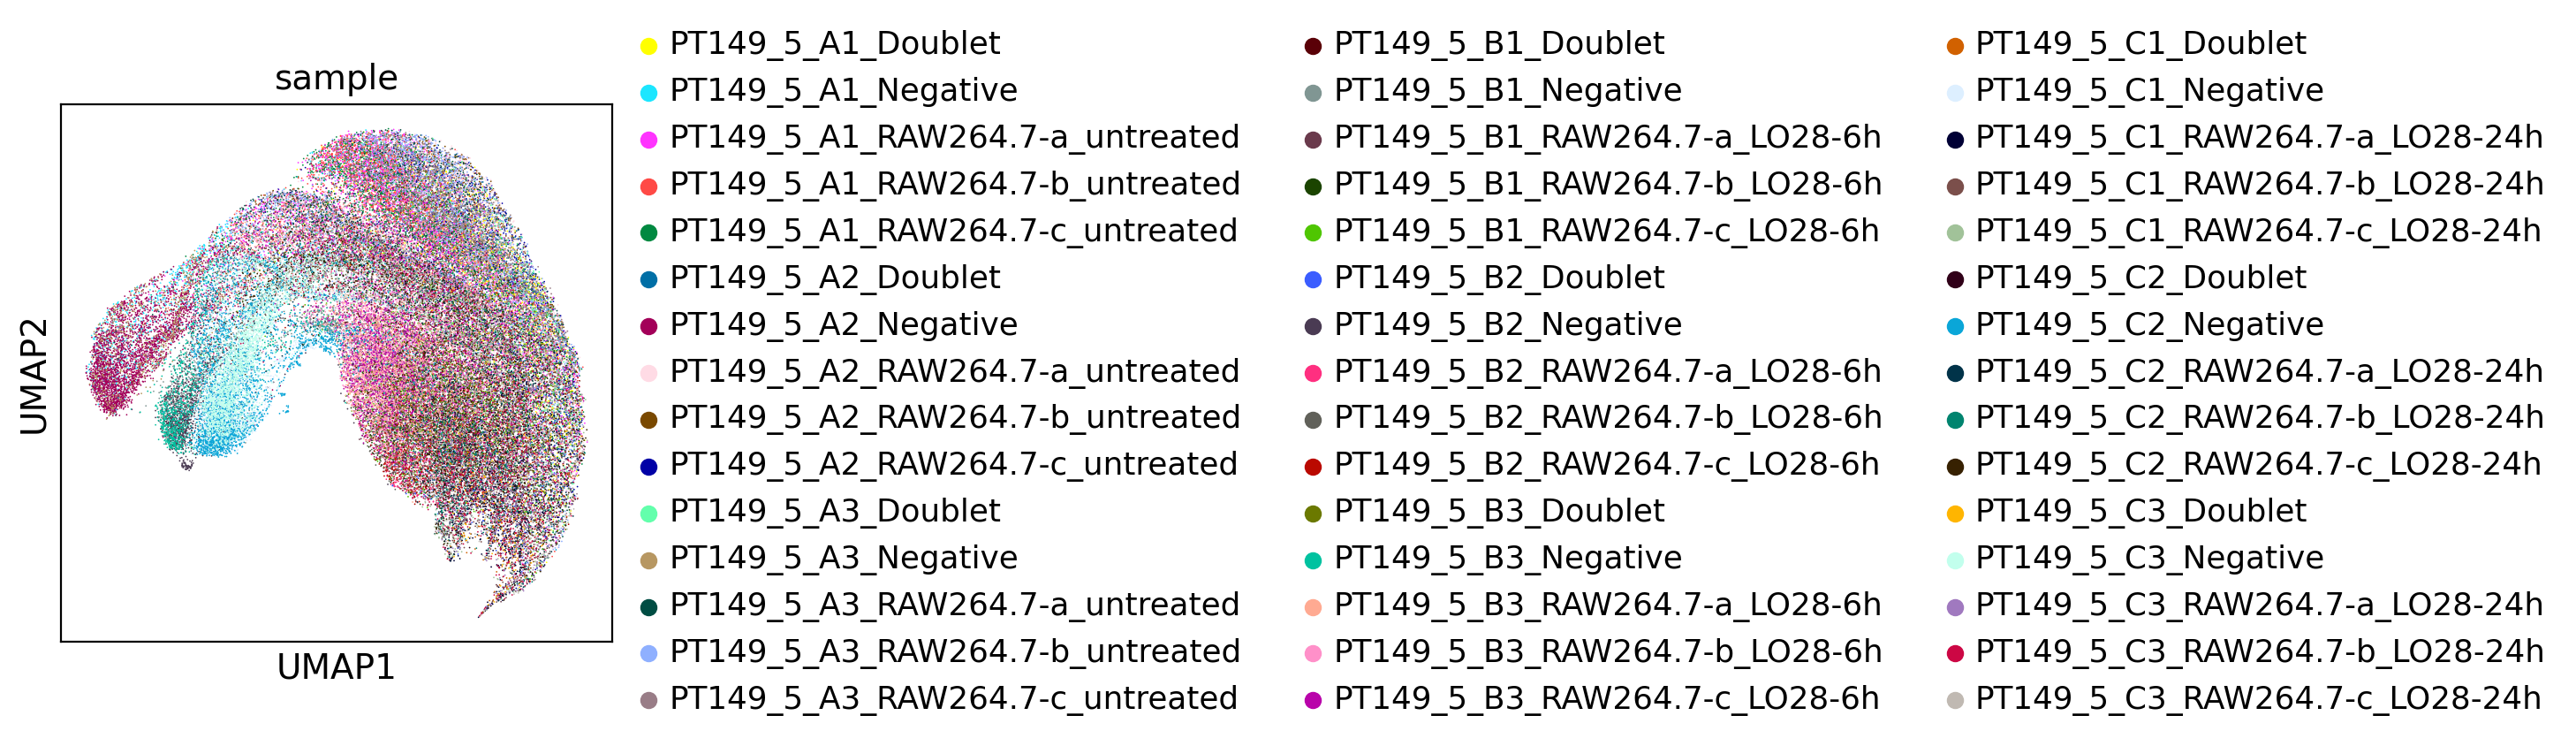

In [15]:
sc.pl.umap(PT141_training, color=['sample'])

### Create expimap model and train it on reference dataset

In [16]:
intr_cvae = sca.models.TRVAE(
    adata = PT141_training,
    condition_key = 'sample',
    hidden_layer_sizes = [256, 256],
    use_mmd = False,
    recon_loss = 'nb',
    mask = PT141_training.varm['I'].T,
    use_decoder_relu = False,
    mmd_instead_kl = False
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 256 45
	Hidden Layer 1 in/out: 256 256
	Mean/Var Layer in/out: 256 2834
Decoder Architecture:
	Masked linear layer in, out and cond:  2834 4000 45


- Set up training parameters 

In [17]:
ALPHA = 0.7

In [18]:
OMEGA = None

In [19]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [ ]:
intr_cvae.train(
    n_epochs = 250, 
    alpha_epoch_anneal = 50, 
    alpha = ALPHA, 
    omega = OMEGA,
    alpha_kl = 0.01,
    weight_decay = 0., 
    early_stopping_kwargs = early_stopping_kwargs,
    use_early_stopping = True,
    seed = 1712,
    print_n_deactive = False)

 |--------------------| 3.6%  - epoch_loss: 2789.31 - epoch_recon_loss: 2785.74 - epoch_kl_loss: 2229.62 - val_loss: 2475.06 - val_recon_loss: 2471.57 - val_kl_loss: 2181.29

### Checl terms in results

In [ ]:
intr_cvae.save('ko_model_big_ref_big')

In [ ]:
inactive_idx = ~(intr_cvae.model.decoder.L0.expr_L.weight.data.norm(p = 2, dim = 0) > 0).cpu().numpy()

In [ ]:
print('Inactive terms:')
[term for i, term in enumerate(PT141_training.uns['terms']) if inactive_idx[i]]

### Visualise manifold

In [ ]:
MEAN = False
PT141_training.obsm['X_cvae'] = intr_cvae.get_latent(PT141_training.X.A, PT141_training.obs['sample'].tolist(),
                                                     mean = MEAN)[:, ~inactive_idx]

In [ ]:
sc.pp.neighbors(PT141_training, use_rep = "X_cvae")
sc.tl.umap(PT141_training)

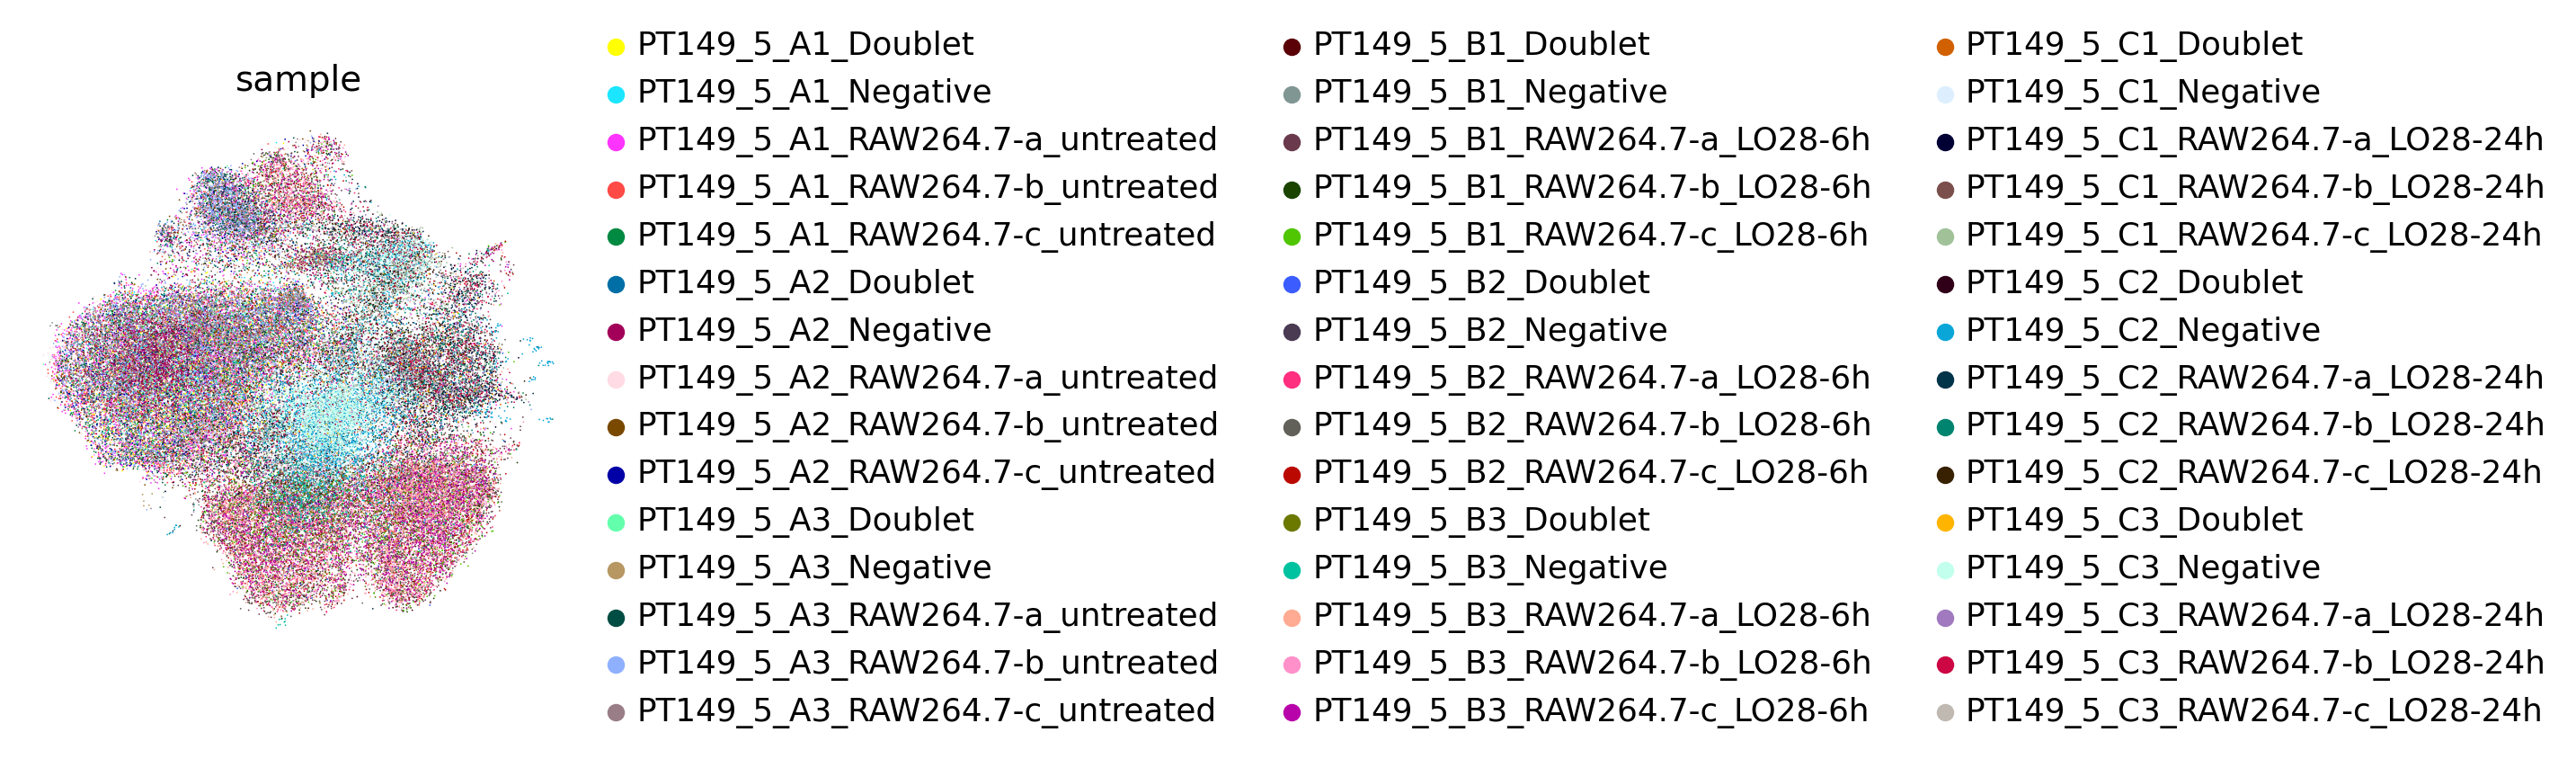

In [32]:
sc.pl.umap(PT141_training, frameon = False, color = ['sample'], wspace=0.5)

### Read in query data 

In [34]:
PT141 = sc.read_h5ad('PT141.h5ad')[:, PT141_training.var_names].copy()


### Format cells for analysis 

### Train on cells

In [35]:
PT141.X = PT141.X.A

In [36]:
q_intr_cvae = sca.models.TRVAE.load_query_data(PT141, intr_cvae)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 256 55
	Hidden Layer 1 in/out: 256 256
	Mean/Var Layer in/out: 256 2834
Decoder Architecture:
	Masked linear layer in, out and cond:  2834 4000 55


In [37]:
q_intr_cvae.train(n_epochs = 200, alpha_epoch_anneal = 20, weight_decay = 0., alpha_kl = 0.001, seed = 1786)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |███████████---------| 59.5%  - epoch_loss: 1890.10 - epoch_recon_loss: 1888.84 - epoch_kl_loss: 1256.18 - val_loss: 1863.07 - val_recon_loss: 1861.81 - val_kl_loss: 1265.34
ADJUSTED LR
 |█████████████-------| 66.0%  - epoch_loss: 1898.61 - epoch_recon_loss: 1897.35 - epoch_kl_loss: 1256.29 - val_loss: 1863.87 - val_recon_loss: 1862.60 - val_kl_loss: 1264.44
ADJUSTED LR
 |█████████████-------| 69.5%  - epoch_loss: 1894.22 - epoch_recon_loss: 1892.96 - epoch_kl_loss: 1256.11 - val_loss: 1861.75 - val_recon_loss: 1860.49 - val_kl_loss: 1264.16
ADJUSTED LR
 |██████████████------| 72.5%  - epoch_loss: 1889.94 - epoch_recon_loss: 1888.68 - epoch_kl_loss: 1256.74 - val_loss: 1860.96 - val_recon_loss: 1859.70 - val_kl_loss: 1264.94
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 123


In [58]:
q_intr_cvae.save('q+ref_all_pathways')

### Visualise joint manifold for query 

In [39]:
PT141.obsm['X_cvae'] = q_intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

         Falling back to preprocessing with `sc.pp.pca` and default params.


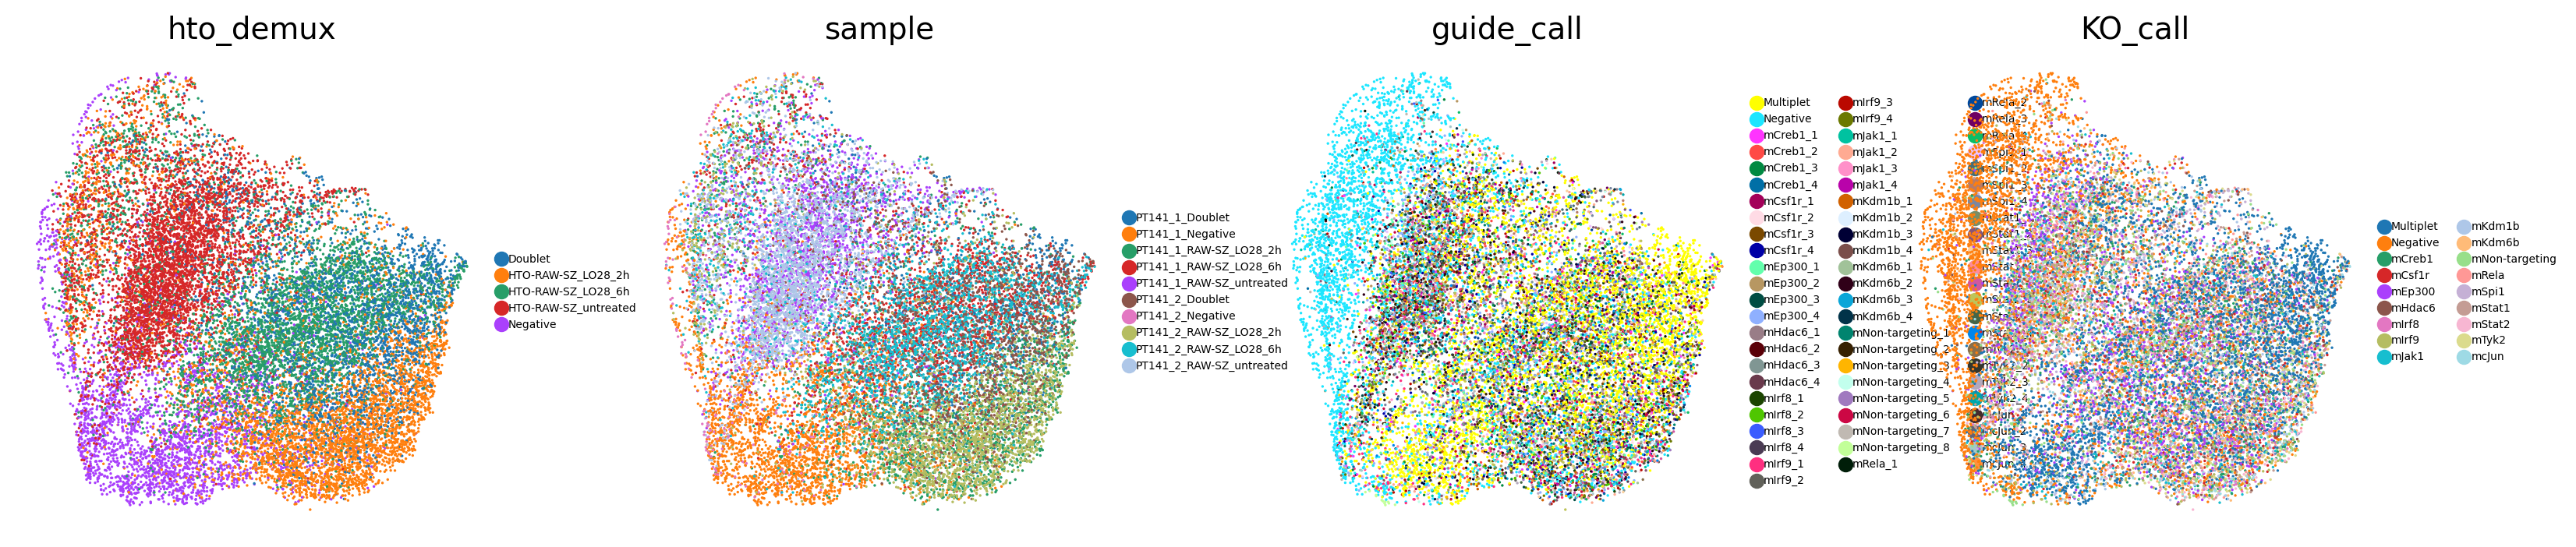

In [40]:
sc.pp.neighbors(PT141)
sc.tl.umap(PT141)
sc.pl.umap(PT141, frameon = False, color = ['hto_demux', 'sample', 'guide_call', 'KO_call'], legend_fontsize = 5)

### Get joint representation

In [41]:
ko_macro = sc.AnnData.concatenate(PT141_training, PT141, batch_key = 'batch_join')
ko_macro

AnnData object with n_obs × n_vars = 96393 × 4000
    obs: 'hto_demux', 'sample', 'pass_QC', 'num_features', 'feature_call', 'num_umis', 'batch', 'guide_call', 'KO_call', 'n_counts', 'batch_join'
    var: 'gene_ids', 'feature_types', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0'
    obsm: 'X_cvae', 'X_pca', 'X_umap'

In [42]:
ko_macro.obsm['X_cvae'] = q_intr_cvae.get_latent(ko_macro.X.A, ko_macro.obs['sample'].tolist(), mean = MEAN)[:, ~inactive_idx]

In [ ]:
sc.pp.neighbors(ko_macro, use_rep = "X_cvae")
sc.tl.umap(ko_macro)

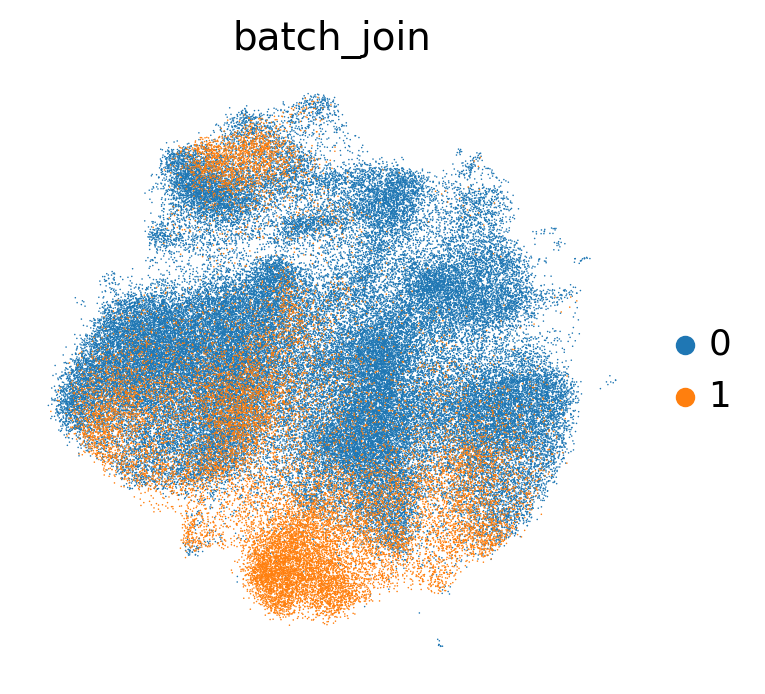

In [47]:
sc.pl.umap(ko_macro, frameon = False, color = ['batch_join'], wspace=0.5)

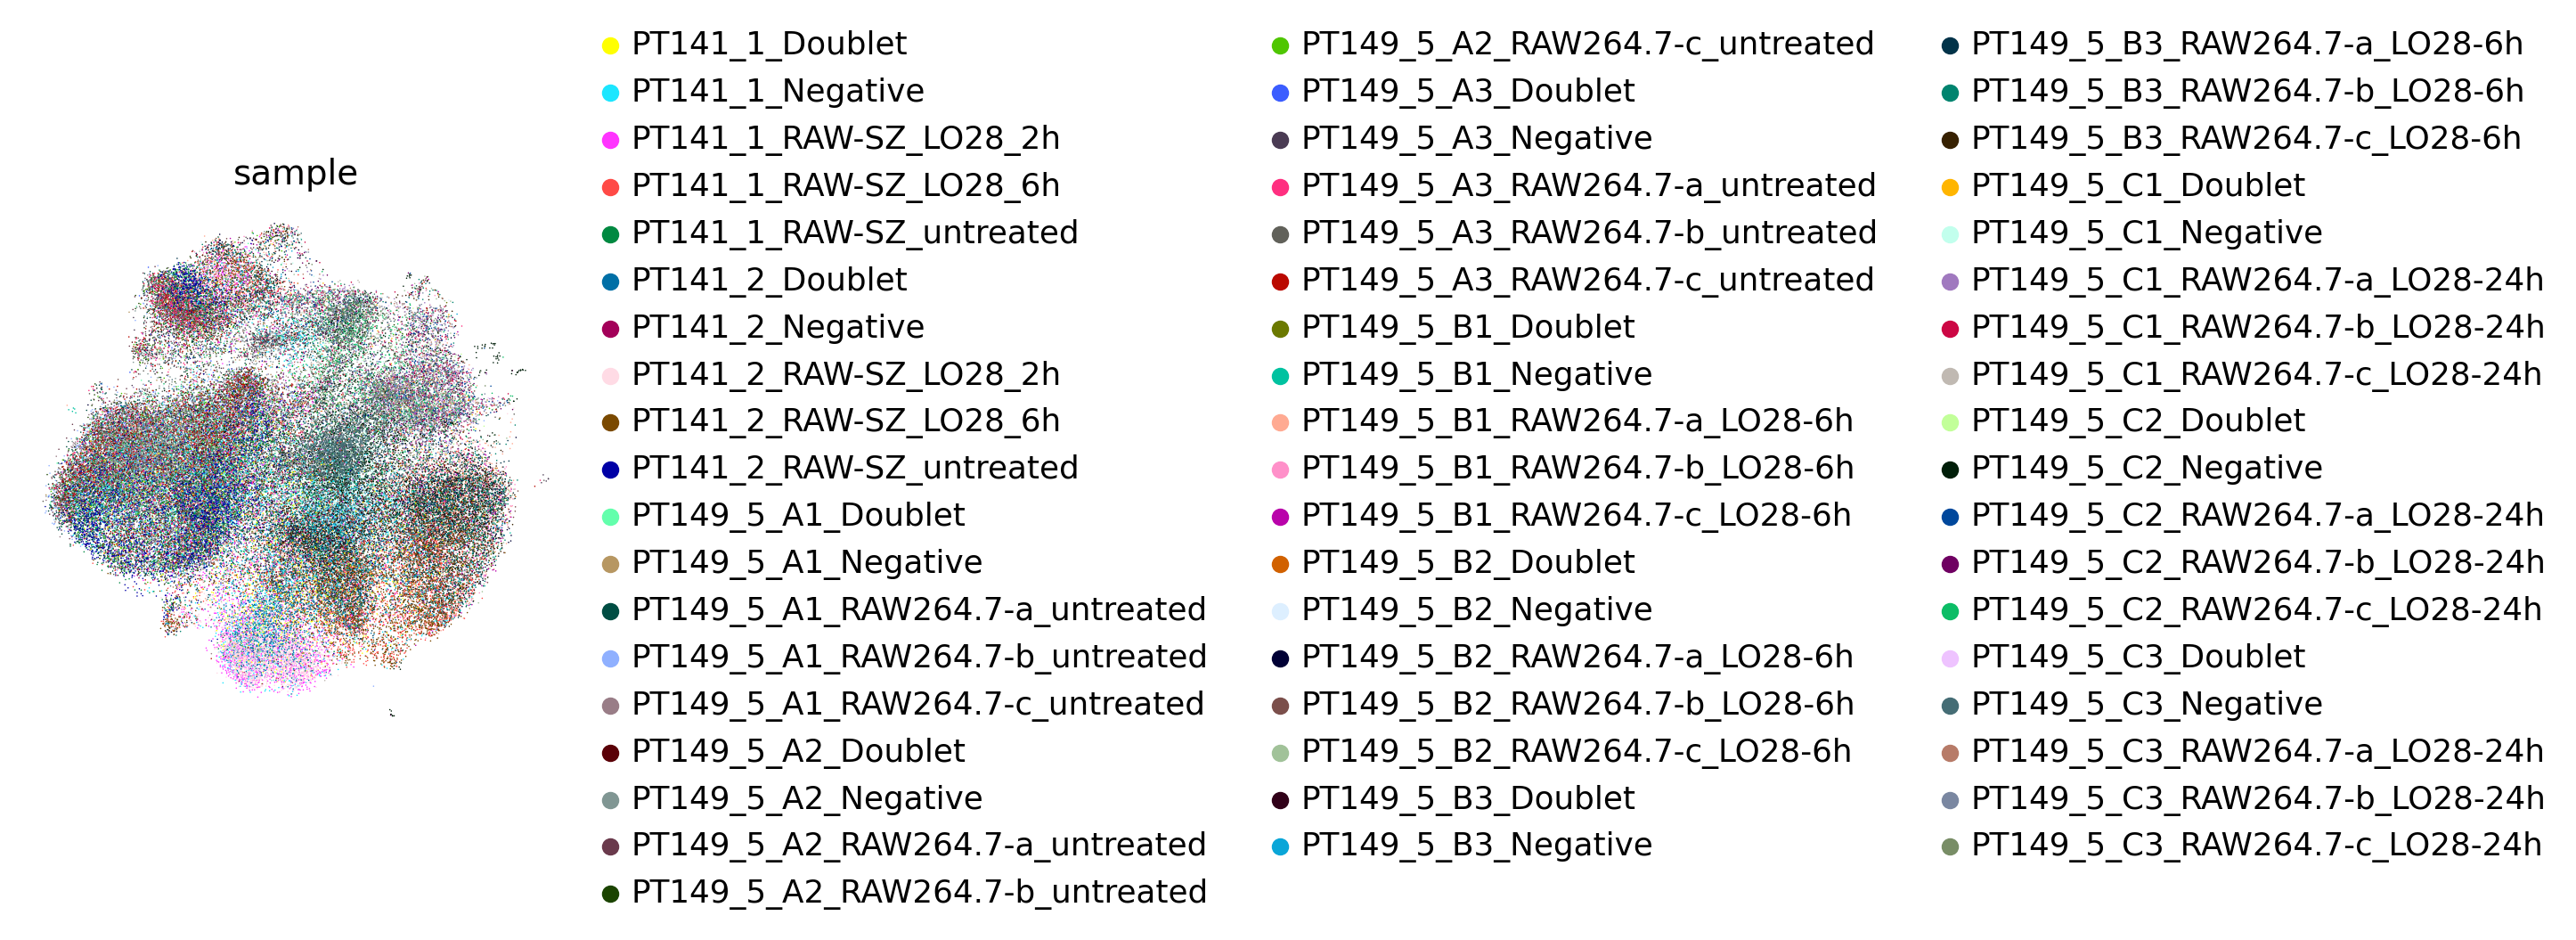

In [48]:
sc.pl.umap(ko_macro, frameon = False, color = ['sample'], wspace=0.5)

In [49]:
ko_macro.uns["terms"] = PT141_training.uns["terms"]

saving raw data  for all genes

In [50]:
adata_ref = sc.read("./PT149.h5ad")
query = sc.read("./PT141.h5ad")

In [51]:
ref_q = sc.AnnData.concatenate(adata_ref, query, batch_key = 'batch_join') 

In [52]:
sc.pp.normalize_per_cell(ref_q)

In [53]:
sc.pp.log1p(ref_q)

In [54]:
ko_macro.raw = ref_q

saving integrated object

In [55]:
ko_macro.write("mac_q_ref_integrated_big.h5ad")